### Multi-armed Bandit
---
![alt bandit](../images/bandit_intro.png)

<div dir="rtl">
مساله Bandit یکی از سناریوهاییه که میشه باهاش مفاهیم اولیه Reinforcement Learning رو ساده تر توضیح داد 
فرض میکنیم یه دستگاه با ۱۰ دسته (environment) داریم ، و ما بعنوان agent هر دفعه با کشیدن یه دسته (action) یک امتیاز  (reward) میگیریم
هدف اینه که با چند بار بازی کردن با این environment به حالتی برسیم که بیشترین reward رو جمع کنیم
</div><div dir="rtl">  
به مساله هایی که انجام دادن یک action تاثیری به environment نداشته باشه یعنی به state دیگه ایی transition انجام نشه Bandit میگن
</div><div dir="rtl"> 
وقتی بازی شروع میشه مقدار reward ایی که با هر action میگیریم رو در یک جدول نگه میداریم و بر اساس اینکه هر action چندبار انتخاب شده و چقدر از بقیه action  ها بهتر هست تصمیم میگیریم که الان کدوم دسته رو بکشیم  به این مرحله تخمین زدن action-value گفته میشه. ولی اگه همیشه به همین روش یعنی به صورت greedy تصمیم بگیریم و مدام از knowledge ایی که جمع کردیم استفاده کنیم (exploit) ممکنه بعضی از action هایی که بهتر  هستن رو هیچوقت کشف (explore) نکنیم ! برای همین راه های متفاوتی برای trade-off بین exploration/exploitation مطرح میشه 
</div>

### Estimating Action Value
---

<div dir="rtl">
برای تخمین action-value از Expection یا میانگین استفاده میکنیم، فرض کنیم زمان t باشه و هربار یه step در environment انجام میدیم. به صورت رایج از (Q_t(a برای نشون دادن ارزش action-a در زمان t استفاده میشه.
فرض کنیم در Multi-armed Bandit برای هر action به صورت random از یک normal distribution به agent یک reward داده میشه. حالا اگه با کمک Q و روش greedy شروع به بازی کنیم چه اتفاقی میفته؟
</div><div dir="rtl">
    البته برای تخمین زدن یکبار run کافی نیست و به صورت رایج چند هزار بار  run ها تکرار و نتایج میانگین گرفته میشه
</div>

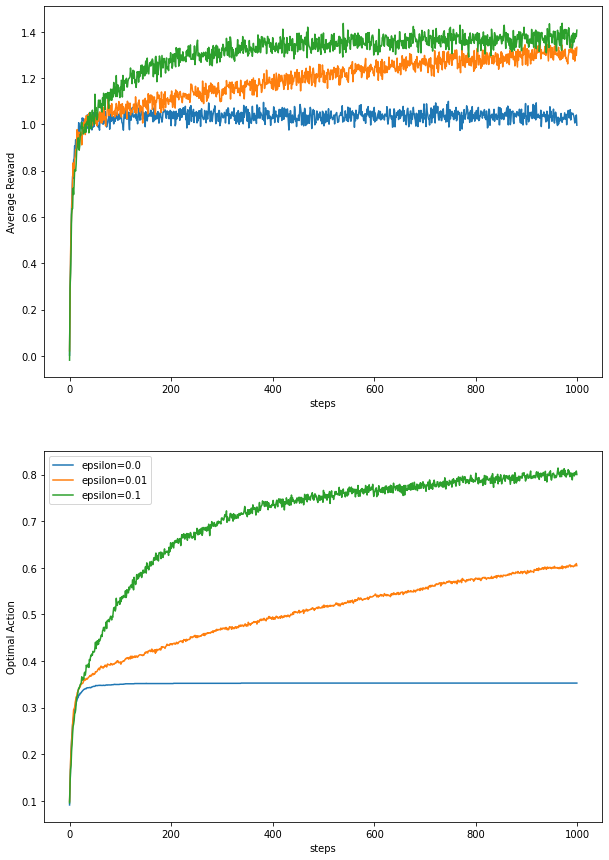

In [3]:
import sys
import numpy as np
sys.path.insert(1, '../../reinforcement_learning/code')
from env.bandit_env import BanditEnv
from agents.bandit_agent import Agent
from matplotlib import pyplot as plt
action_space = 10
state_space = 1
num_runs = 2000
max_steps = 1000
def run_greedy(action_space, state_space, epsilon, optimal_initial_value=0.):
    agent = Agent(action_space=action_space, state_space=state_space, epsilon=epsilon, e_greedy=True, optimal_initial_value=optimal_initial_value)
    env = BanditEnv(action_space)
    optimal_actions = np.zeros(max_steps)
    rewards = np.zeros(max_steps)
    for r in range(num_runs):
        env.reset()
        agent.reset()
        for t in range(max_steps):
            action = agent.act()
            reward = env.step(action)
            agent.step(reward=reward, action=action, sample_average=True)
            rewards[t]+=reward
            if action == env.best_action:
                optimal_actions[t]+=1
    return rewards/num_runs , optimal_actions/num_runs
plt.figure(figsize=(10,15))
plt.subplot()
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
for i, epsilon in enumerate([0., 0.01, 0.1]):
    rewards, optimal_actions = run_greedy(action_space=action_space, state_space=state_space, epsilon=epsilon)
    ax1.plot(rewards, label=f'epsilon={epsilon}')
    ax2.plot(optimal_actions, label=f'epsilon={epsilon}')
ax1.set_xlabel('steps')
ax1.set_ylabel('Average Reward')
ax2.set_xlabel('steps')
ax2.set_ylabel('Optimal Action')
plt.legend()
plt.show()

<div dir="rtl">
روش مطلقا greedy خیلی زود در انتخاب هاش دچار مشکل میشه ، اصطلاحا در suboptimal action گیر میفته. برای بهتر شدن این روش یه مفهوم جدید تعریف میکنیم با عنوان epsilon-greedy که epsilon در نقش معامله گر بین ۲ حالت exploration و exploitation عمل میکنه. خلاصه مطلب اینه که epsilon از مقداری نزدیک ۱ شروع میشه و طی زمان با کاهش یا decay به مقداری خیلی کمی میرسه و ثابت میشه. agent احتمال epsilon - 1 انتخاب greedy میده و در بقیه موارد به صورت random یکی از action های موجود رو انتخاب میکنه
</div>

### Optimistic Initial Value
<div dir="rtl">

<div dir="rtl">
یکی از روش هایی که agent رو تشویق میکنه به explore کردن، دادن یه مقدار اولیه بزرگ به هرaction-value هست، این کار باعث میشه action های بیشتری انتخاب بشن تا زمانیکه Q به مقدار واقعیش نزدیک بشه. ولی این روش برای nonstationary environment به درد نمیخوره چون محیط در طول زمان در حال تغییره 

In [ ]:
plt.figure(figsize=(10,8))
for epsilon, optimal_initial_value in [(0.,5.), (0.1,0.)]:
    rewards, optimal_actions = run_greedy(action_space=action_space, state_space=state_space, \
                                          epsilon=epsilon, optimal_initial_value=optimal_initial_value)
    plt.plot(optimal_actions, label=f'epsilon={epsilon} Q={optimal_initial_value}')
plt.xlabel('steps')
plt.ylabel('Optimal Action')
plt.legend()
plt.show()

### Upper Confidence Bound
<div dir="rtl">
    به غیر از روش های greedy، روش ucb هم خیلی خوب عمل میکنه ولی زیاد محبوبیتی نداره. این روش به جای استفاده از انتخاب action به صورت تصادفی برای explore کردن از confidence interval استفاده میکنه و actionهایی رو انتخاب میکنه که تعداد دفعات کمتری انتخاب شدن


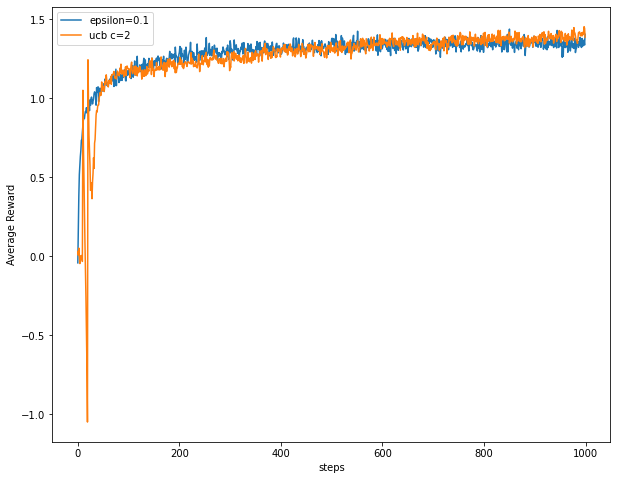

In [5]:
def run_ucb(action_space, state_space, epsilon):
    agent = Agent(action_space=action_space, state_space=state_space,\
                  step_size=0.1, ucb_const=2., ucb=True)
    env = BanditEnv(action_space)
    optimal_actions = np.zeros(max_steps)
    rewards = np.zeros(max_steps)
    for r in range(num_runs):
        env.reset()
        agent.reset()
        for t in range(max_steps):
            action = agent.act()
            reward = env.step(action)
            agent.step(reward=reward, action=action)
            rewards[t]+=reward
            if action == env.best_action:
                optimal_actions[t]+=1
    return rewards/num_runs , optimal_actions/num_runs
action_space = 10
state_space = 1
num_runs = 2000
max_steps = 1000

plt.figure(figsize=(10,8))
e_rewards, e_optimal_actions = run_greedy(action_space=action_space, state_space=state_space, epsilon=0.1)
plt.plot(e_rewards, label=f'epsilon={0.1}')
ucb_rewards, ucb_optimal_actions = run_ucb(action_space=action_space, state_space=state_space, epsilon=0.)
plt.plot(ucb_rewards, label=f'ucb c={2}')
plt.xlabel('steps')
plt.ylabel('Average Reward')
plt.legend()
plt.show()